In [ ]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [ ]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [ ]:
dataset = 'GTZAN'
new_spects = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_spects.pkl'

if new_spects or not os.path.isfile(pickle_filename):
    spects, labels = fe.extract_spectrograms(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([spects, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        spects, labels = pickle.load(f)
    print(f'{spects.shape[0]} spectrograms extracted')

In [4]:
scaler = StandardScaler()
#scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(spects, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

In [5]:
list(zip(*train_data))[0][0].shape

In [6]:
#Input = (N,Cin,Lin) 
    #N = batch size
    #Cin = Channels (np.shape(spectrograms[0])[0])
    #Lin = np.shape(spectrograms[0])[1]
#Lout = ((Lin + 2*padding -dilation*(kernel_size-1)-1)/stride) + 1

In [162]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,
                               kernel_size=(5, 5),
                               padding=(2, 2))
        self.maxpool1 = nn.MaxPool2d((4,2))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=(5, 5),
                               padding=(2, 2))
        self.maxpool2 = nn.MaxPool2d((5,4))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=(5, 5),
                               padding=(2, 2))
        self.maxpool3 = nn.MaxPool2d((16,8))
        self.bn3 = nn.BatchNorm2d(128)

        self.fc = nn.Linear(2*2*128, 10)
        
        self.drop_layer = nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = x.unsqueeze_(1)
        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.drop_layer(x)
        
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.maxpool2(x)
        x = self.drop_layer(x)
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.maxpool3(x)
        x = self.drop_layer(x)
        
        x = x.view(-1, 2*2*128)
        
        x = self.fc(x)
        
        return x

In [163]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [164]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [165]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [166]:
# Hyperparameters
#input_size_cnn = 640
#hidden_size_cnn = [320, 160, 80]
#input_size_dnn = 640
#hidden_size_dnn = [200, 80, 30]
#num_classes = 10
#kernel_size = 5
train_batch_size = 100
valid_batch_size = 100

num_epochs = 50
learning_rate = 0.0001

In [167]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = CNNClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 4.048328
Train Epoch: 1 [400/600 (66%)]	Loss: 3.6363
Train Epoch: 1 [600/600 (100%)]	Loss: 3.582944

Validation set: Average loss: 2.3351, Accuracy: 19/200 (9%)

Train Epoch: 2 [200/600 (33%)]	Loss: 3.464067
Train Epoch: 2 [400/600 (66%)]	Loss: 2.985503
Train Epoch: 2 [600/600 (100%)]	Loss: 3.035789

Validation set: Average loss: 2.3204, Accuracy: 21/200 (10%)

Train Epoch: 3 [200/600 (33%)]	Loss: 3.283848
Train Epoch: 3 [400/600 (66%)]	Loss: 2.868279
Train Epoch: 3 [600/600 (100%)]	Loss: 3.164182

Validation set: Average loss: 2.2997, Accuracy: 30/200 (15%)

Train Epoch: 4 [200/600 (33%)]	Loss: 3.065087
Train Epoch: 4 [400/600 (66%)]	Loss: 2.855564
Train Epoch: 4 [600/600 (100%)]	Loss: 2.856096

Validation set: Average loss: 2.2747, Accuracy: 37/200 (18%)

Train Epoch: 5 [200/600 (33%)]	Loss: 3.034734
Train Epoch: 5 [400/600 (66%)]	Loss: 2.820991
Train Epoch: 5 [600/600 (100%)]	Loss: 2.779975

Validation set: Average loss: 2.2486, Accuracy: 46/200 

Train Epoch: 41 [400/600 (66%)]	Loss: 1.608243
Train Epoch: 41 [600/600 (100%)]	Loss: 1.641637

Validation set: Average loss: 1.6771, Accuracy: 84/200 (42%)

Train Epoch: 42 [200/600 (33%)]	Loss: 1.656303
Train Epoch: 42 [400/600 (66%)]	Loss: 1.641173
Train Epoch: 42 [600/600 (100%)]	Loss: 1.57995

Validation set: Average loss: 1.6636, Accuracy: 85/200 (42%)

Train Epoch: 43 [200/600 (33%)]	Loss: 1.409805
Train Epoch: 43 [400/600 (66%)]	Loss: 1.556634
Train Epoch: 43 [600/600 (100%)]	Loss: 1.482416

Validation set: Average loss: 1.6531, Accuracy: 87/200 (43%)

Train Epoch: 44 [200/600 (33%)]	Loss: 1.547997
Train Epoch: 44 [400/600 (66%)]	Loss: 1.449954
Train Epoch: 44 [600/600 (100%)]	Loss: 1.598492

Validation set: Average loss: 1.6438, Accuracy: 87/200 (43%)

Train Epoch: 45 [200/600 (33%)]	Loss: 1.501699
Train Epoch: 45 [400/600 (66%)]	Loss: 1.628929
Train Epoch: 45 [600/600 (100%)]	Loss: 1.604516

Validation set: Average loss: 1.6414, Accuracy: 87/200 (43%)

Train Epoch: 46 [200/60

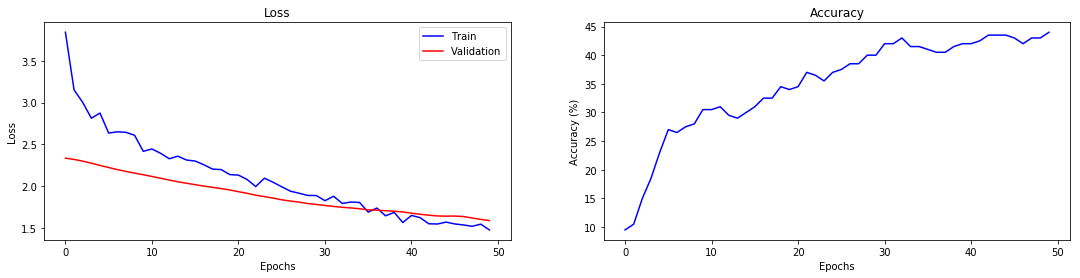

In [168]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [155]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 113/200 (56%)

